# Import Modules and Datasets

In [2]:
import pandas
import tensorflow as tf
import numpy
import matplotlib.pyplot as plt

In [3]:
path = "./datasets-main/AirQuality/OpenAQSanFran.csv"
dt = pandas.read_csv(path)
dt['monthdate'] = dt['utc'].apply(lambda x: x[5:10])

In [4]:
# dt.head()

### Predict-obj: Object to predict, default to NO2

In [5]:
# Re-run all chunks after this object is changed
predict_obj = "pm25"

cities = dt.location.unique()
por = int(len(cities)*0.8)
train = cities[:por]
test = cities[por:]

spec = dt[([x in train for x in dt['location']]) & (dt['parameter'] == predict_obj)]
spec2 = dt[([x in test for x in dt['location']]) & (dt['parameter'] == predict_obj)]
# plt.plot(spec['value'])
# plt.plot(spec2['value'])

In [6]:
# xs 

In [7]:
# spec.iloc[0]['utc'][:]

In [8]:
means = spec.groupby(["monthdate", 'location'])['value'].mean()
spec['datemean'] = spec.apply(lambda x: means[x['monthdate']][x['location']], axis=1)
means2 = spec2.groupby(["monthdate", 'location'])['value'].mean()
spec2['datemean'] = spec2.apply(lambda x: means2[x['monthdate']][x['location']], axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Create test and train dataset

In [9]:
lookback = 5

xs = pandas.DataFrame(means)
tests = pandas.DataFrame(means2)
xs['dates'] = xs.index
tests['dates'] = tests.index
xs = xs[['dates', 'value']]
tests = tests[['dates', 'value']]
i = 1
while i < lookback+1:
    xs['value-%s' % i] = xs.shift(periods = i)['value']
    i += 1
xs = xs.dropna()
# xs
i = 1
while i < lookback+1:
    tests['value-%s' % i] = tests.shift(periods = i)['value']
    i += 1
tests = tests.dropna()

### Create Model for mean

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape = [lookback]),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = 0.01)
model.compile(loss="mse", optimizer = optimizer, metrics=['mae', 'mse'])

In [11]:
# testx

### Split for X and y matrices

In [12]:
xlabs = xs[["value-%s" % (x+1) for x in range(lookback)]] * 100
ylabs = xs['value'] * 100
testx = tests[["value-%s" % (x+1) for x in range(lookback)]] * 100
testy = tests['value'] * 100

### Train model and evaluate

In [13]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print("")
        print(".", end="")

EPOCHS = 100        
        
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history=model.fit(xlabs, ylabs, epochs=EPOCHS,
                 validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])
        
# history = model.fit(xlabs, ylabs, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintDot()])


..............................................................

In [14]:
hist = pandas.DataFrame(history.history)
hist['epoch'] = history.epoch
# hist.tail()

In [15]:
loss, mae, mse = model.evaluate(testx, testy, verbose=2)
print("Testing set mean abs error: {:5.2f} MPG".format(mae))

5/5 - 0s - loss: 2300402.5000 - mae: 835.1882 - mse: 2300402.5000
Testing set mean abs error: 835.19 MPG


### Demo for predicting mean

In [16]:
loc = means2.index.unique('location')

In [17]:
res = {}
for item in loc:
    test3 = pandas.DataFrame(means2[:, item])
    i = 1
    while i < lookback+1:
        test3['value-%s' % i] = test3.shift(periods = i)['value']
        i += 1
    test3 = test3.dropna()
    preds = model.predict(test3[["value-%s"%(x+1) for x in range(lookback)]] * 100).T
    res[item] = preds
# res

In [18]:
# preds = model.predict(test3[["value-%s"%(x+1) for x in range(lookback)]] * 100).T

In [19]:
# outs = [[preds[0][x], test3.iloc[x]['value']] for x in range(len(test3))]

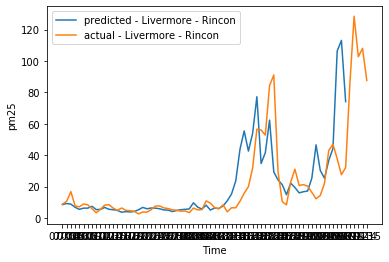

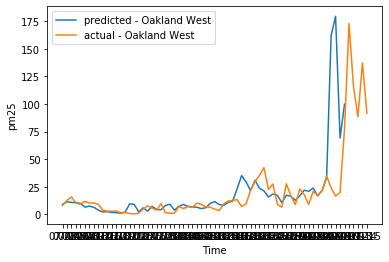

In [20]:
# plt.plot(preds[0] / 100, label="predicted")
# plt.plot(means2[:, "Livermore - Rincon"], label='actual')
# plt.legend()
# plt.xlabel("Time")
# plt.ylabel(predict_obj)
for item in res:
    plt.plot(res[item][0] / 100, label = "predicted - %s" % item)
    plt.plot(means2[:, item], label = "actual - %s" % item)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(predict_obj)
    plt.show()

In [21]:
# Residuals
# outs = [(x[1] - x[0]) for x in outs]
# plt.plot(outs)

# Create Model for hourly rates

In [22]:
spec = spec.sort_values(['location', "utc"])
spec2 = spec2.sort_values(['location', 'utc'])

In [23]:
spec['hourly'] = spec['value'] / spec['datemean']
spec2['hourly'] = spec2['value'] / spec2['datemean']

In [24]:
lookback = 5

xs = pandas.DataFrame(spec['hourly'])
tests = pandas.DataFrame(spec2['hourly'])

i = 1
while i < lookback+1:
    xs['hourly-%s' % i] = xs.shift(periods = i)['hourly']
    i += 1
xs = xs.dropna()

i = 1
while i < lookback+1:
    tests['hourly-%s' % i] = tests.shift(periods = i)['hourly']
    i += 1
tests = tests.dropna()

In [25]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape = [lookback]),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr = 0.01)
model2.compile(loss="mse", optimizer = optimizer, metrics=['mae', 'mse'])

In [26]:
xlabs = xs[["hourly-%s" % (x+1) for x in range(lookback)]]
ylabs = xs['hourly']
testx = tests[["hourly-%s" % (x+1) for x in range(lookback)]]
testy = tests['hourly']

### Train and Evaluation

In [27]:
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print("")
        print(".", end="")

early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history=model2.fit(xlabs, ylabs, epochs=EPOCHS,
                 validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])
        
# EPOCHS = 100
# history = model.fit(xlabs, ylabs, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintDot()])


......................................................

In [28]:
hist = pandas.DataFrame(history.history)
hist['epoch'] = history.epoch

In [29]:
loss, mae, mse = model2.evaluate(testx, testy, verbose=2)
print("Testing set mean abs error: {:5.2f} MPG".format(mae))

80/80 - 0s - loss: 0.5692 - mae: 0.3583 - mse: 0.5692
Testing set mean abs error:  0.36 MPG


In [30]:
# preds = model2.predict(testx).T[0]

In [31]:
# outs = [[preds[x], testy.iloc[x]] for x in range(len(testy))]

In [32]:
# plt.plot(outs)

# General Prediction - run all three chunks below. 

**Changing location: change the location in the quotes**. 

In [33]:
df2 = pandas.concat([spec, spec2])

In [34]:
df2.location.unique()

array(['Concord', 'Laney College', 'Oakland', 'Pleasanton - Owens C',
       'Redwood City', 'San Francisco', 'San Pablo - Rumrill',
       'San Rafael', 'Livermore - Rincon', 'Oakland West'], dtype=object)

In [35]:

## CHANGE HERE
location = "Concord"


# DO NOT CHANGE, JUST RUN
spec3 = df2[df2['location'] == location]

lo = pandas.DataFrame(spec3['hourly'])

i = 1
while i < lookback+1:
    lo['hourly-%s' % i] = lo.shift(periods = i)['hourly']
    i += 1
lo = lo.dropna()

try:
    preds = model2.predict(lo[['hourly-%s' % (x+1) for x in range(5)]])
except UnboundLocalError as e:
    print("No %s data for %s found." % (predict_obj, location))

# outs = [[preds[x], lo.iloc[x]['hourly']] for x in range(len(lo))]
# plt.plot(outs)

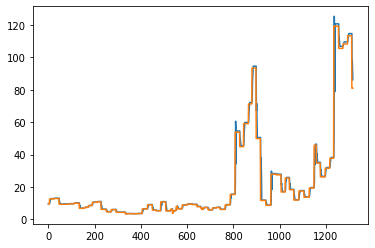

In [36]:
means = pandas.DataFrame(spec3['datemean'])
means['value'] = means['datemean']
del means['datemean']
i = 1
while i < lookback + 1:
    means['value-%s' % i] = means.shift(periods=i)['value']
    i +=1

means = means.dropna()
preds2 = model.predict(means[['value-%s' % (x+1) for x in range(5)]] * 100) / 100
outs2 = [[preds2[x], means.iloc[x]['value']] for x in range(len(means))]
plt.plot(outs2)

Mean Absolute Error for location Concord: [9.349724]
Mean Squared Error for location Concord: [457.04608]


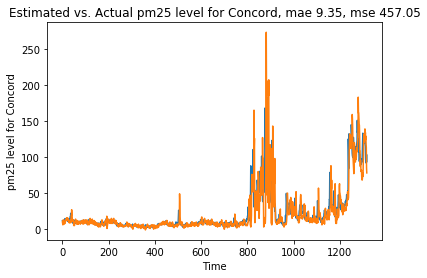

In [37]:
predicted = [preds2[x] * preds[x] for x in range(len(preds))]
actual = spec3['value']
allpoints = [[predicted[x], actual.iloc[x]] for x in range(len(predicted))]
allpointsabs = [abs(x[1] - x[0]) for x in allpoints]
allpointssq = [(x[1] - x[0])**2 for x in allpoints]
mae = sum(allpointsabs) / len(allpointsabs)
mse = sum(allpointssq) / len(allpointssq)
print("Mean Absolute Error for location %s:"%location, mae)
print("Mean Squared Error for location %s:"%location, mse)
plt.plot([[predicted[x], actual.iloc[x]] for x in range(len(predicted))])
plt.plot()
plt.xlabel("Time")
plt.ylabel("%s level for %s" % (predict_obj, location))
plt.title("Estimated vs. Actual %s level for %s, mae %s, mse %s" % (predict_obj, location, round(mae[0], 2), round(mse[0], 2)))
plt.show()

In [52]:
path = "./datasets-main/AirQuality/OpenAQDurham.csv"
dt = pandas.read_csv(path)
dt['monthdate'] = dt['utc'].apply(lambda x: x[5:10])

In [53]:
cities = dt.location.unique()
por = int(len(cities)*0.8)
train = cities[:por]
test = cities[por:]

spec = dt[([x in train for x in dt['location']]) & (dt['parameter'] == predict_obj)]
spec2 = dt[([x in test for x in dt['location']]) & (dt['parameter'] == predict_obj)]

In [54]:
means = spec.groupby(["monthdate", 'location'])['value'].mean()
spec['datemean'] = spec.apply(lambda x: means[x['monthdate']][x['location']], axis=1)
means2 = spec2.groupby(["monthdate", 'location'])['value'].mean()
spec2['datemean'] = spec2.apply(lambda x: means2[x['monthdate']][x['location']], axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [55]:
spec = spec.sort_values(['location', "utc"])
spec2 = spec2.sort_values(['location', 'utc'])

In [56]:
spec['hourly'] = spec['value'] / spec['datemean']
spec2['hourly'] = spec2['value'] / spec2['datemean']

In [57]:
df2 = pandas.concat([spec, spec2])

In [58]:
df2['year'] = df2['utc'].apply(lambda x: x[:4])

In [59]:
df2 = df2[df2['year'] == "2020"]

In [62]:

## CHANGE HERE
location = "Durham Armory"


# DO NOT CHANGE, JUST RUN
spec3 = df2[df2['location'] == location]

lo = pandas.DataFrame(spec3['hourly'])

i = 1
while i < lookback+1:
    lo['hourly-%s' % i] = lo.shift(periods = i)['hourly']
    i += 1
lo = lo.dropna()

try:
    preds = model2.predict(lo[['hourly-%s' % (x+1) for x in range(5)]])
except UnboundLocalError as e:
    print("No %s data for %s found." % (predict_obj, location))

# outs = [[preds[x], lo.iloc[x]['hourly']] for x in range(len(lo))]
# plt.plot(outs)

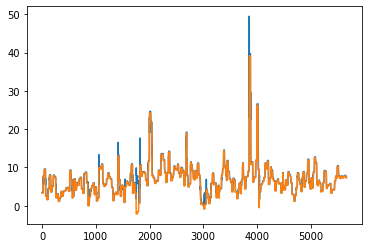

In [63]:
means = pandas.DataFrame(spec3['datemean'])
means['value'] = means['datemean']
del means['datemean']
i = 1
while i < lookback + 1:
    means['value-%s' % i] = means.shift(periods=i)['value']
    i +=1

means = means.dropna()
preds2 = model.predict(means[['value-%s' % (x+1) for x in range(5)]] * 100) / 100
outs2 = [[preds2[x], means.iloc[x]['value']] for x in range(len(means))]
plt.plot(outs2)

Mean Absolute Error for location Durham Armory: 2.7963729943618914
Mean Squared Error for location Durham Armory: 16.844075774176122


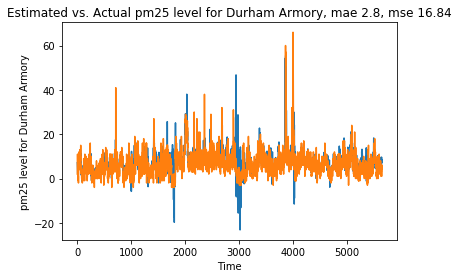

In [90]:
predicted = [preds2[x] * preds[x] for x in range(len(preds))]
actual = spec3['value']
allpoints = [[predicted[x], actual.iloc[x]] for x in range(len(predicted))]
allpointsabs = [abs(x[1] - x[0][0]) for x in allpoints]
allpointssq = [((x[1] - x[0][0])**2) for x in allpoints]
allpointsabs = [x for x in allpointsabs if not pandas.isna(x)]
allpointssq = [x for x in allpointssq if not pandas.isna(x)]
mae = sum(allpointsabs) / len(allpointsabs)
mse = sum(allpointssq) / len(allpointssq)
print("Mean Absolute Error for location %s:"%location, mae)
print("Mean Squared Error for location %s:"%location, mse)
plt.plot([[predicted[x], actual.iloc[x]] for x in range(len(predicted))])
plt.plot()
plt.xlabel("Time")
plt.ylabel("%s level for %s" % (predict_obj, location))
plt.title("Estimated vs. Actual %s level for %s, mae %s, mse %s" % (predict_obj, location, round(mae, 2), round(mse, 2)))
plt.show()

In [77]:
pandas.isna(numpy.nan)

True

In [61]:
df2.location.unique()

array(['Durham Armory', 'Burdens Creek'], dtype=object)

In [88]:
allpoints

[[array([7.143051], dtype=float32), 2.0],
 [array([6.2349634], dtype=float32), 3.0],
 [array([4.9944057], dtype=float32), 6.0],
 [array([5.2897897], dtype=float32), 8.0],
 [array([3.9523628], dtype=float32), 11.0],
 [array([3.2596142], dtype=float32), 9.0],
 [array([2.762947], dtype=float32), 7.0],
 [array([2.0757372], dtype=float32), 8.0],
 [array([2.0430284], dtype=float32), 6.0],
 [array([2.0628197], dtype=float32), 4.0],
 [array([3.3819702], dtype=float32), 3.0],
 [array([5.2072206], dtype=float32), 0.0],
 [array([3.5297487], dtype=float32), 0.0],
 [array([1.5402675], dtype=float32), 1.0],
 [array([2.3336732], dtype=float32), 2.0],
 [array([2.04202], dtype=float32), 4.0],
 [array([1.0009915], dtype=float32), 3.0],
 [array([1.6392771], dtype=float32), -1.0],
 [array([4.1563654], dtype=float32), 1.0],
 [array([5.452441], dtype=float32), 1.0],
 [array([4.9498463], dtype=float32), -2.0],
 [array([8.383695], dtype=float32), -2.0],
 [array([6.35241], dtype=float32), 2.0],
 [array([6.2569

In [83]:
pandas.isna(numpy.nan)

True

In [84]:
pandas.isna(3)

False